In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

import random

## Language dataset

In [46]:
class LanguageDataset(Dataset):
    '''
    Args:
    - min_length (int):  minimum length of the generated sequences
    - max_length (int):  maximum length of the generated sequences
    - p (float):         probability of generating a valid sequence
    - num_samples (int): number of samples to generate
    
    Returns:
    list of tuples (sequence, label) where sequence is a one-hot encoded tensor and label is 0 or 1.
    '''
    def __init__(self, num_samples,loader_type, test_length=None):
        self.min_length = 1
        self.max_length = 20
        self.num_samples = num_samples
        self.loader_type = loader_type
        self.length = test_length
        
        self.train_set = self.generate_training_samples()
        self.valid_set = self.generate_validation_samples()
        self.test_set = self.generate_test_samples()
        self.samples = self.generate_samples(loader_type)
        self.avg_len = self.average_length()

    def generate_valid_sequence(self, n):
        return 'a' * n + 'b' * n + 'c' * n

    def generate_invalid_sequence(self, length):
        return ''.join(np.random.choice(['a', 'b', 'c'], size=length))

    def generate_training_samples(self):
        valid_sizes = [3, 6, 15, 18]
        valid_samples_train = []
        n = self.num_samples // (2*len(valid_sizes)) # number of samples for each valid size
        for valid_size in valid_sizes:
            for _ in range(n):
                sequence = self.generate_valid_sequence(valid_size//3)
                valid_samples_train.append((sequence, int(self.is_language(sequence))))
        
        invalid_samples = []
        for _ in range(n):
            sequence = self.generate_invalid_sequence(np.random.choice(range(1,self.max_length+1)))

            if self.is_language(sequence) == False:
                invalid_samples.append((sequence, int(self.is_language(sequence))))
            else:
                sequence = sequence.replace('a', np.random.choice(['b', 'c'])) 
                invalid_samples.append((sequence, int(self.is_language(sequence))))
        
        samples = valid_samples_train + invalid_samples
        random.shuffle(samples)
        return samples

    def generate_validation_samples(self):
        valid_sizes = [9, 12]
        valid_samples_valid = []
        n = self.num_samples // (2*len(valid_sizes)) # number of samples for each valid size
        for valid_size in valid_sizes:
            for _ in range(n):
                sequence = self.generate_valid_sequence(valid_size//3)
                valid_samples_valid.append((sequence, int(self.is_language(sequence))))

        invalid_samples = []
        for _ in range(n):
            sequence = self.generate_invalid_sequence(np.random.choice(range(1,self.max_length+1)))

            if self.is_language(sequence) == False:
                invalid_samples.append((sequence, int(self.is_language(sequence))))
            else:
                sequence = sequence.replace('a', np.random.choice(['b', 'c']))  
                invalid_samples.append((sequence, int(self.is_language(sequence))))

        samples = valid_samples_valid + invalid_samples
        random.shuffle(samples)
        return samples

    def generate_test_samples(self):
        min_length = 21
        max_length = 100
        split = np.random.rand()
        n = self.num_samples

        valid_samples_test = []
        for _ in range(int(n*split)):
            if self.length is not None:
                sequence = self.generate_valid_sequence(self.length//3)

            else: 
                sequence = self.generate_valid_sequence(np.random.choice(range(min_length//3, max_length//3)))
            valid_samples_test.append((sequence, int(self.is_language(sequence))))


        invalid_samples = []
        for _ in range(int(n*(1-split))):
            if self.length is not None:
                sequence = self.generate_invalid_sequence(self.length)
            else: 
                sequence = self.generate_invalid_sequence(np.random.choice(range(min_length, max_length)))

            if self.is_language(sequence) == False:
                invalid_samples.append((sequence, int(self.is_language(sequence))))
            else:
                sequence = sequence.replace('a', np.random.choice(['b', 'c'])) 
                invalid_samples.append((sequence, int(self.is_language(sequence))))
        samples = valid_samples_test + invalid_samples
        random.shuffle(samples)
        return samples

    def generate_samples(self, loader_type):
        if loader_type == 'train':
            return self.train_set
        elif loader_type == 'validation':
            return self.valid_set
        elif loader_type == 'test':
            return self.test_set
        else:
            raise ValueError('Invalid loader type. Valid loader types are: train, validation, test.')
    
    def is_language(self, sequence):
        length = len(sequence)
        if length % 3 != 0:
            return False
        
        # calculate n
        n = length // 3

        if sequence[:n] == 'a' * n and sequence[n:2*n] == 'b' * n and sequence[2*n:] == 'c' * n:
            return True
        
        return False

    def average_length(self):
        avg_train = np.mean([len(sequence) for sequence, _ in self.train_set])
        avg_valid = np.mean([len(sequence) for sequence, _ in self.valid_set])
        avg_test = np.mean([len(sequence) for sequence, _ in self.test_set])

        return avg_train, avg_valid, avg_test
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sequence, label = self.samples[idx]
        indices = torch.tensor([ord(c) - ord('a') for c in sequence], dtype=torch.long)
        one_hot_sequence = torch.nn.functional.one_hot(indices, num_classes=3).float()
        return one_hot_sequence, torch.tensor(label)


def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    labels = torch.stack(labels)
    return sequences_padded, labels



def generate_data(num_samples, loader_type, batch_size=32, test_length=None):
    dataset = LanguageDataset(num_samples, loader_type, test_length)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    return data_loader
    

## Model definition

In [17]:
class LSTM(nn.Module):
    '''
    Args:
    - input_size (int):     The number of input features per time step (e.g., 3 for 'a', 'b', 'c')
    - hidden_size (int):    The number of features in the hidden state of the LSTM
    - output_size (int):    The number of output classes (e.g., 2 for binary classification)
    - n_layers (int):       The number of recurrent layers in the LSTM
    
    Returns:
    The predicted output after passing through the LSTM model.
    '''
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(input.size(0))
        output, (hidden, cell) = self.lstm(input)
        output = self.fc(output[:, -1, :])  # Use the output of the last time step
        output = self.softmax(output)
        return output

    def init_hidden(self, batch_size):
        return (torch.zeros(self.n_layers, batch_size, self.hidden_size),
                torch.zeros(self.n_layers, batch_size, self.hidden_size))

## Training and evaluation functions

In [18]:
def eval_model(model, data_loader, criterion='accuracy'):
    '''
    Args:
    - model (nn.Module):        The trained model
    - data_loader (DataLoader): The DataLoader for the evaluation data
    - criterion (str):          The evaluation criterion ('accuracy' or 'f1')

    Returns:
    The evaluation score (accuracy or F1) of the model on the evaluation data.
    '''
    model.eval()  # Set model to eval mode
    true_labels = []
    pred_labels = []

    with torch.no_grad():  # Deactivate gradients for the following code
        for sequences, labels in data_loader:  # Iterate over batches
            hidden = model.init_hidden(sequences.size(0))
            outputs = model(sequences, hidden)
            _, predicted = torch.max(outputs.data, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    if criterion == 'accuracy':
        return accuracy_score(true_labels, pred_labels)
    elif criterion == 'f1':
        return f1_score(true_labels, pred_labels)
    else:
        raise ValueError("Invalid criterion. Choose 'accuracy' or 'f1'.")

In [19]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    '''
    Args:
    - model (nn.Module):         The model to train
    - train_loader (DataLoader): The DataLoader for the training data
    - val_loader (DataLoader):   The DataLoader for the validation data
    - criterion (nn.Module):     The loss function
    - optimizer (torch.optim):   The optimizer
    - num_epochs (int):          The number of epochs to train
    
    Returns:
    The best model found during training with the corresponding best validation accuracy obtained.
    '''
    best_val_f1 = 0
    best_val_acc = 0
    best_model = None
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for sequences, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()


        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')
        total_loss = 0
        
        # Evaluate the model on the validation set using the eval_model function
        val_f1 = eval_model(model, val_loader, criterion='f1')
        val_acc = eval_model(model, val_loader, criterion='accuracy')
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_val_acc = val_acc
            best_model = model
        '''
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_f1 = val_f1
            best_model = model
        '''

    return best_model, best_val_f1, best_val_acc

### Generate data

In [47]:
train_loader = generate_data(1000, 'train', batch_size=32)
val_loader = generate_data(100, 'validation', batch_size=32)
test_loader = generate_data(100, 'test', batch_size=32)

In [21]:
"""# After generating the data loader, split it into train and validation sets
train_data_loader = generate_data(1, 20, 0.5, 1000, 32)

train_size = int(0.7 * len(train_data_loader.dataset))

# select train_size number of samples for training
train_data, val_data = random_split(train_data_loader.dataset, [train_size, len(train_data_loader.dataset) - train_size])

test_data = generate_data(21, 100, 0.5, 1000, 32).dataset

# Create separate data loaders for train, validation, and test sets
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, collate_fn=collate_fn)
"""

'# After generating the data loader, split it into train and validation sets\ntrain_data_loader = generate_data(1, 20, 0.5, 1000, 32)\n\ntrain_size = int(0.7 * len(train_data_loader.dataset))\n\n# select train_size number of samples for training\ntrain_data, val_data = random_split(train_data_loader.dataset, [train_size, len(train_data_loader.dataset) - train_size])\n\ntest_data = generate_data(21, 100, 0.5, 1000, 32).dataset\n\n# Create separate data loaders for train, validation, and test sets\ntrain_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)\nval_loader = DataLoader(val_data, batch_size=32, shuffle=False, collate_fn=collate_fn)\ntest_loader = DataLoader(test_data, batch_size=32, shuffle=False, collate_fn=collate_fn)\n'

In [34]:
model = LSTM(3, 4, 2)
criterion = nn.CrossEntropyLoss()
        #criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float))
optimizer = optim.Adam(model.parameters(), lr=0.001)
        
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=400)

Epoch 1/400, Loss: 0.6654
Epoch 2/400, Loss: 0.6540
Epoch 3/400, Loss: 0.6425
Epoch 4/400, Loss: 0.6298
Epoch 5/400, Loss: 0.6159
Epoch 6/400, Loss: 0.6014
Epoch 7/400, Loss: 0.5848
Epoch 8/400, Loss: 0.5644
Epoch 9/400, Loss: 0.5523
Epoch 10/400, Loss: 0.5472
Epoch 11/400, Loss: 0.5360
Epoch 12/400, Loss: 0.5335
Epoch 13/400, Loss: 0.5269
Epoch 14/400, Loss: 0.5262
Epoch 15/400, Loss: 0.5224
Epoch 16/400, Loss: 0.5184
Epoch 17/400, Loss: 0.5181
Epoch 18/400, Loss: 0.5161
Epoch 19/400, Loss: 0.5074
Epoch 20/400, Loss: 0.5030
Epoch 21/400, Loss: 0.4986
Epoch 22/400, Loss: 0.4877
Epoch 23/400, Loss: 0.4780
Epoch 24/400, Loss: 0.4665
Epoch 25/400, Loss: 0.4552
Epoch 26/400, Loss: 0.4436
Epoch 27/400, Loss: 0.4341
Epoch 28/400, Loss: 0.4317
Epoch 29/400, Loss: 0.4210
Epoch 30/400, Loss: 0.4129
Epoch 31/400, Loss: 0.4082
Epoch 32/400, Loss: 0.4002
Epoch 33/400, Loss: 0.3950
Epoch 34/400, Loss: 0.3944
Epoch 35/400, Loss: 0.4096
Epoch 36/400, Loss: 0.4149
Epoch 37/400, Loss: 0.3968
Epoch 38/4

(LSTM(
   (lstm): LSTM(3, 4, batch_first=True)
   (fc): Linear(in_features=4, out_features=2, bias=True)
   (softmax): Softmax(dim=1)
 ),
 0.9433962264150945,
 0.92)

In [23]:
labels = [label for _, label in train_loader.dataset]
class_counts = np.bincount(labels)
class_weights = 1.0 / class_counts

weights = [class_weights[label] for label in labels]
weights = torch.tensor(weights, dtype=torch.float)
sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))

In [24]:
# loop through first batch
for sequences, labels in train_loader:
    print(model(sequences))
    print(labels)
    break

tensor([[0.9098, 0.0902],
        [0.0083, 0.9917],
        [0.9089, 0.0911],
        [0.0082, 0.9918],
        [0.0082, 0.9918],
        [0.0087, 0.9913],
        [0.0081, 0.9919],
        [0.0081, 0.9919],
        [0.0082, 0.9918],
        [0.9021, 0.0979],
        [0.0082, 0.9918],
        [0.0083, 0.9917],
        [0.0082, 0.9918],
        [0.0081, 0.9919],
        [0.0081, 0.9919],
        [0.9072, 0.0928],
        [0.0081, 0.9919],
        [0.9100, 0.0900],
        [0.0087, 0.9913],
        [0.0083, 0.9917],
        [0.8966, 0.1034],
        [0.0083, 0.9917],
        [0.0081, 0.9919],
        [0.9094, 0.0906],
        [0.0087, 0.9913],
        [0.8939, 0.1061],
        [0.0087, 0.9913],
        [0.0083, 0.9917],
        [0.0081, 0.9919],
        [0.0087, 0.9913],
        [0.0082, 0.9918],
        [0.0081, 0.9919]], grad_fn=<SoftmaxBackward0>)
tensor([0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 1])


In [25]:
#train_loader = DataLoader(train_data, batch_size=32, sampler=sampler, collate_fn=collate_fn)

## Hyperparameter tuning

In [36]:
input_size = 3  # 'a', 'b', 'c'
output_size = 2  # 0 or 1
hidden_sizes = [16, 32, 64]
learning_rates = [0.001, 0.01, 0.1]

best_val_acc = 0
best_val_f1 = 0
best_model_acc = None
best_model_f1 = None

for hidden_size in hidden_sizes:
    for lr in learning_rates:
        model = LSTM(input_size, hidden_size, output_size)
        criterion = nn.CrossEntropyLoss()
        #criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float))
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        model, val_f1, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100)
        print (val_acc)
        print (val_f1)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_acc = model
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_f1 = model

print(f'Best validation accuracy: {np.round(best_val_acc,3)}')
print (best_model_acc)

print(f'Best validation F1: {np.round(best_val_f1,3)}')
print (best_model_f1)

Epoch 1/100, Loss: 0.6337
Epoch 2/100, Loss: 0.6045
Epoch 3/100, Loss: 0.5561
Epoch 4/100, Loss: 0.5269
Epoch 5/100, Loss: 0.5171
Epoch 6/100, Loss: 0.5202
Epoch 7/100, Loss: 0.5180
Epoch 8/100, Loss: 0.5107
Epoch 9/100, Loss: 0.5158
Epoch 10/100, Loss: 0.5128
Epoch 11/100, Loss: 0.5140
Epoch 12/100, Loss: 0.5165
Epoch 13/100, Loss: 0.5137
Epoch 14/100, Loss: 0.5122
Epoch 15/100, Loss: 0.5162
Epoch 16/100, Loss: 0.5134
Epoch 17/100, Loss: 0.5134
Epoch 18/100, Loss: 0.5147
Epoch 19/100, Loss: 0.5146
Epoch 20/100, Loss: 0.5146
Epoch 21/100, Loss: 0.5132
Epoch 22/100, Loss: 0.5173
Epoch 23/100, Loss: 0.5145
Epoch 24/100, Loss: 0.5131
Epoch 25/100, Loss: 0.5172
Epoch 26/100, Loss: 0.5158
Epoch 27/100, Loss: 0.5144
Epoch 28/100, Loss: 0.5130
Epoch 29/100, Loss: 0.5144
Epoch 30/100, Loss: 0.5144
Epoch 31/100, Loss: 0.5116
Epoch 32/100, Loss: 0.5143
Epoch 33/100, Loss: 0.5143
Epoch 34/100, Loss: 0.5130
Epoch 35/100, Loss: 0.5116
Epoch 36/100, Loss: 0.5143
Epoch 37/100, Loss: 0.5115
Epoch 38/1

## Evaluation

In [37]:
best_model = best_model_f1

# Evaluate the model on the validation set
val_accuracy = eval_model(best_model, val_loader, criterion='accuracy')
val_f1_score = eval_model(best_model, val_loader, criterion='f1')

print(f'Validation Accuracy: {np.round(val_accuracy,3)}')
print(f'Validation F1 Score: {val_f1_score}')

# Evaluate the model on the test set
test_accuracy = eval_model(best_model, test_loader, criterion='accuracy')
test_f1_score = eval_model(best_model, test_loader, criterion='f1')

print(f'Test Accuracy: {np.round(test_accuracy,3)}')
print(f'Test F1 Score: {test_f1_score}')

Validation Accuracy: 0.973
Validation F1 Score: 0.9803921568627451
Test Accuracy: 0.263
Test F1 Score: 0.40650406504065045


## Plot results

In [48]:
# Initialize lists to store performance metrics
accuracy_per_length = []
f1_score_per_length = []

# Evaluate the model on sequences of lengths ranging from 21 to 100
for length in range(21, 101):
    test_data = generate_data(100,'test', test_length=length).dataset
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False, collate_fn=collate_fn)
    
    # Evaluate the model on the test set
    test_accuracy = eval_model(best_model, test_loader, criterion='accuracy')
    test_f1_score = eval_model(best_model, test_loader, criterion='f1')
    
    accuracy_per_length.append(test_accuracy)
    f1_score_per_length.append(test_f1_score)

In [52]:
# Load vanilla RNN
rnn_accuracy_per_length = np.loadtxt('RNN_acc.csv', delimiter=',')
rnn_f1_score_per_length = np.loadtxt('RNN_f1.csv', delimiter=',')

## Plot results from LSTM

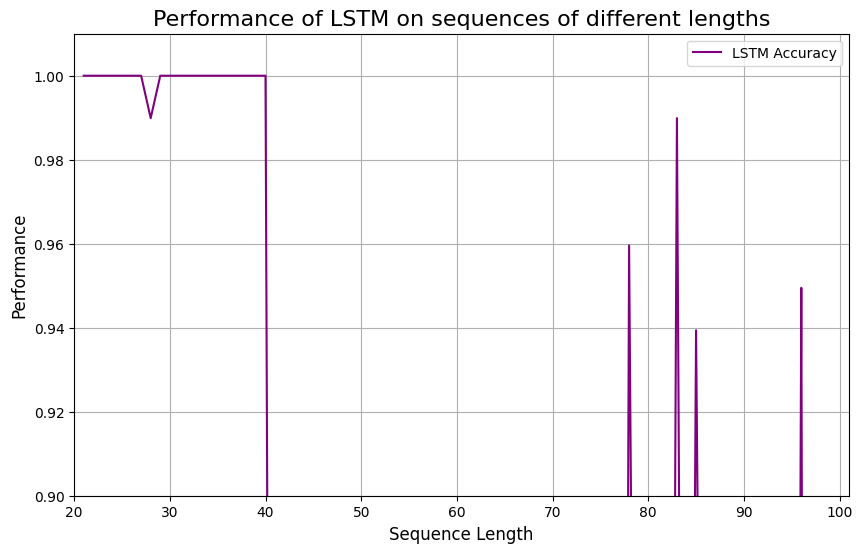

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(range(21, 101), accuracy_per_length, label='LSTM Accuracy', color='purple')
plt.xlim(20, 101)
plt.ylim(0.9, 1.01)
plt.xlabel('Sequence Length', fontsize=12)
plt.ylabel('Performance', fontsize=12)
plt.title('Performance of LSTM on sequences of different lengths', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

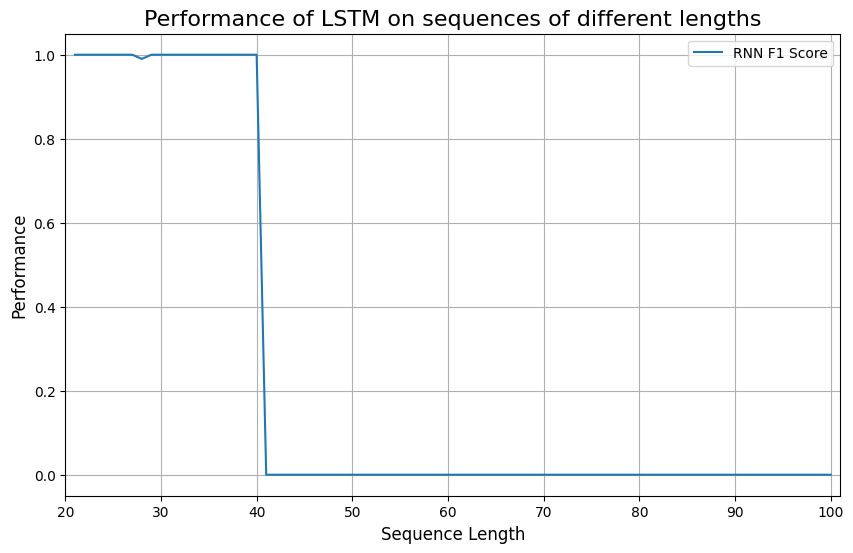

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(range(21, 101), f1_score_per_length, label='RNN F1 Score')
plt.xlim(20, 101)
plt.xlabel('Sequence Length', fontsize=12)
plt.ylabel('Performance', fontsize=12)
plt.title('Performance of LSTM on sequences of different lengths', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

## Plot results from LSTM and RNN

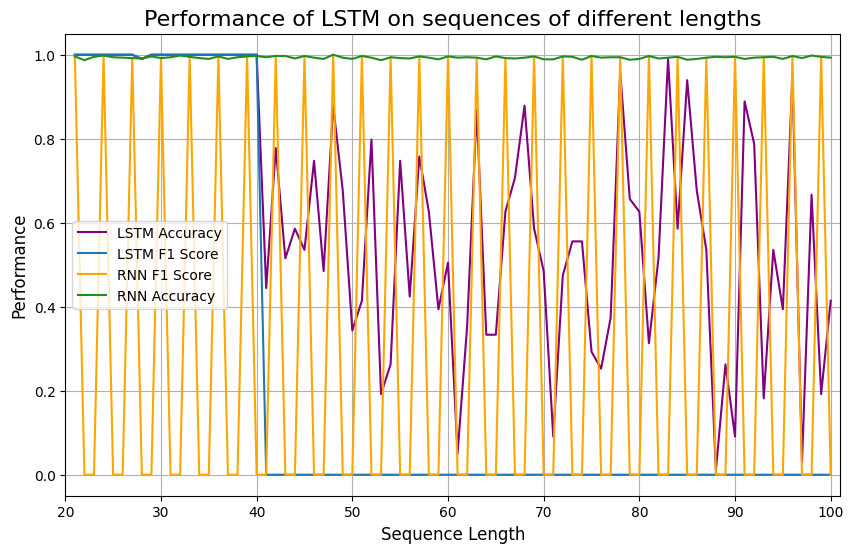

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(range(21, 101), accuracy_per_length, label='LSTM Accuracy', color='purple')
plt.plot(range(21, 101), f1_score_per_length, label='LSTM F1 Score')
plt.plot(range(21, 101), rnn_f1_score_per_length, label='RNN F1 Score', color='orange')
plt.plot(range(21, 101), rnn_accuracy_per_length, label='RNN Accuracy', color='forestgreen')
#plt.ylim(0.997, 1)
plt.xlim(20, 101)
plt.xlabel('Sequence Length', fontsize=12)
plt.ylabel('Performance', fontsize=12)
plt.title('Performance of LSTM on sequences of different lengths', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()